In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import leastsq , curve_fit
from scipy.signal import find_peaks
#from lmfit.models import ExponentialModel, GaussianModel,LorentzianModel, QuadraticModel


In [ ]:
#pip install lmfit


In [ ]:
#pl-data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving pl.xlsx to pl.xlsx


In [2]:
pl= pd.read_excel('pl.xlsx')
pl.dropna(axis=1, how='all',inplace=True)
pl.dropna(axis=0, how='any',inplace=True)
pl=pl.copy().rename(columns={'Unnamed: 0': 'wavelength'})


In [3]:
#x
x=(((pl.iloc[:,0:1]).to_numpy()).flatten())

#y
#sample1
y1=(((pl.iloc[:,1:2]).to_numpy()).flatten())
#sample2
y2=(((pl.iloc[:,2:3]).to_numpy()).flatten())
#sample3
y3=(((pl.iloc[:,3:4]).to_numpy()).flatten())
#sample4
y4=(((pl.iloc[:,4:5]).to_numpy()).flatten())
#sample5
y5=(((pl.iloc[:,5:6]).to_numpy()).flatten())


# curve fitting

In [48]:
def lorentzian(x, x0, a, gam):
    return a * gam**2 / (gam**2 + (x - x0)**2)

def multi_lorentz(x, params):
    off = params[0]
    paramsRest = params[1:]
    assert not (len(paramsRest) % 3)
    return off + sum([lorentzian(x, *paramsRest[i : i + 3]) for i in range(0, len(paramsRest), 3)])

def res_multi_lorentz(params, xData, yData):
    diff = [multi_lorentz(x, params) - y for x, y in zip(xData, yData)]
    return diff

def fit(x, y):

    yData = y
    xData = x

    yGround = min(yData)
    yData = yData - yGround
    yAmp = max(yData)
    yData = yData / yAmp

    # initial properties of peaks
    pk, properties = find_peaks(yData, height=0.05, width=3)
    # extract peak heights and FWHM
    I = properties['peak_heights']
    fwhm = properties['widths']

    guess = [0]

    for i in range(len(pk)):
        guess.append(pk[i])
        guess.append(I[i])
        guess.append(fwhm[i])

    guess = np.array(guess)

    popt, pcov = leastsq(res_multi_lorentz, x0=guess, args=(xData, yData), maxfev=20000)

    testData = [multi_lorentz(x, popt) for x in xData]
    fitData = [yGround + yAmp * multi_lorentz(x, popt) for x in xData]


    
    # Find peaks in the fitted data
    pk_fit, properties_fit = find_peaks(fitData, height=0.05, width=3)

    # Extract peak heights and FWHM from the fitted data
    I_fit = properties_fit['peak_heights']
    fwhm_fit = properties_fit['widths']

    # Extract peak positions from the fitted data
    peak_positions_fit = xData[pk_fit]

    # plot
    #ax is used for the first subplot displaying the original data, peaks, and the test data. bx is used for the second subplot displaying the original data and the fitted data.
    # Create a DataFrame from the results
    # res_df= pd.DataFrame({
    #     'amplitude': I_fit,
    #     'fwhm': fwhm_fit,
    #     'peak_positions': peak_positions_fit
    # })
    # # Set the index to 'peak 1' and 'peak 2'
    # res_df.index = ['peak 1', 'peak 2']


    return fitData, peak_positions_fit

def plot(x,y , fitData, peak_positions_fit, filename):
    
    xData = x
    y0 = y
    
    plt.figure(figsize=(5, 3))
    plt.plot(xData, y0, ls='', marker='o', markersize=1, label='Experimental Data')
    plt.plot(xData, fitData, label='Fitted Data')
    
    # Plot vertical lines at each x position
    for pos in peak_positions_fit:
        plt.axvline(x=pos, color='r', linestyle='--')
    
    from matplotlib.lines import Line2D

    # Create a custom legend entry for the peak positions
    custom_legend = [Line2D([0], [0], color='r', linestyle='--', lw=2, label='Peak Positions')]
    
    # Get handles and labels for current axes
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Combine existing legend entries with the custom legend entry
    all_handles = handles + custom_legend
    all_labels = labels + ['Peak Positions']
    
    # Add the custom legend entry to the existing legend
    plt.legend(all_handles, all_labels, fontsize="9", loc="upper left") 
    
    # Save static plot
    title='PL Data with Fitted Lorentzian Peaks'
    xaxis= "Wavelength"
    yaxis='Intensity'
    plt.xlabel(xaxis, fontsize=12)
    plt.ylabel(yaxis, fontsize=12)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename + '_PL.png')

In [5]:
fitData_y1, peak_positions_fit_y1 = fit(x,y1)

c:\Users\majmo\Git\ml_demystified\venv\lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 20000.
  warnings.warn(errors[info][0], RuntimeWarning)


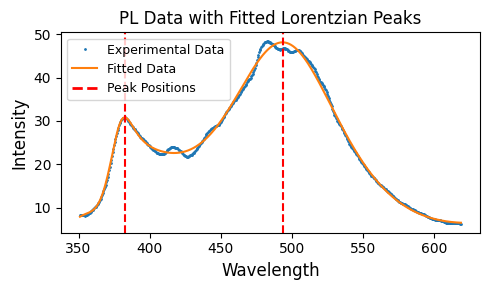

In [32]:
plot(x,y1, fitData_y1, peak_positions_fit_y1, "sample1")

In [66]:
fitData_y2, peak_positions_fit_y2 = fit(x,y2)

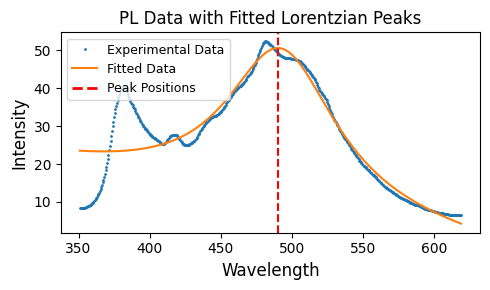

In [68]:
plot(x,y2, fitData_y2, peak_positions_fit_y2, "sample2")

In [39]:
fitData_y3, peak_positions_fit_y3 = fit(x,y3)

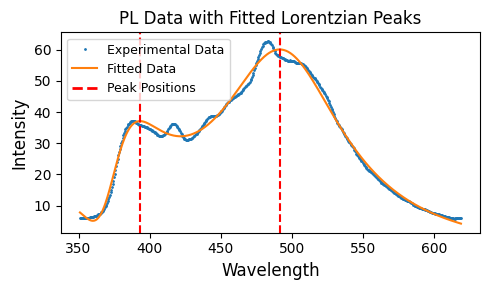

In [40]:
plot(x,y3, fitData_y3, peak_positions_fit_y3 , "sample3")

In [41]:
fitData_y4, peak_positions_fit_y4 = fit(x,y4)

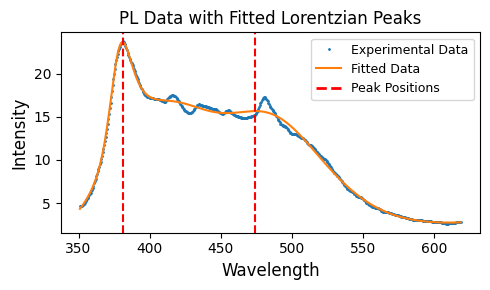

In [44]:
plot(x,y4, fitData_y4, peak_positions_fit_y4 , "sample4")

In [45]:
fitData_y5, peak_positions_fit_y5= fit(x,y5)

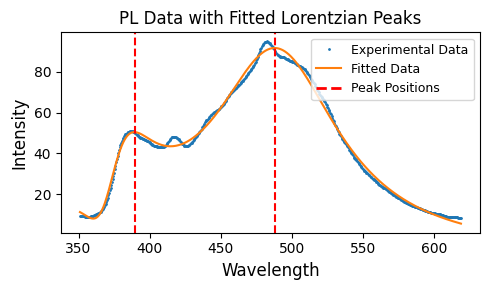

In [46]:
plot(x,y5, fitData_y5, peak_positions_fit_y5 , "sample5")

#spam ❎

In [ ]:
#lmfit
def lmfitt (x,y,a,s,rough_peak_positions):#a=amplitude s=sigma
    xdat = x
    ydat = y

    def add_peak(prefix, center, amplitude=a, sigma=s):
        peak = LorentzianModel(prefix=prefix)
        pars = peak.make_params()
        pars[prefix + 'center'].set(center)
        pars[prefix + 'amplitude'].set(amplitude)
        pars[prefix + 'sigma'].set(sigma, min=0)
        return peak, pars


    model = QuadraticModel(prefix='bkg_')
    params = model.make_params(a=0, b=0, c=0)

    rough_peak_positions = rough_peak_positions

    for i, cen in enumerate(rough_peak_positions):

        peak, pars = add_peak('lz%d_' % (i+1), cen)
        model = model + peak
        params.update(pars)


    init = model.eval(params, x=xdat)
    result = model.fit(ydat, params, x=xdat)
    comps = result.eval_components()


    plt.figure( figsize=( 10, 10 ) )

    plt.plot(xdat, ydat, label='data')
    plt.plot(xdat, result.best_fit, label='best fit')

    for name, comp in comps.items():
        plt.plot(xdat, comp,'--', label=name)
    plt.legend(loc='upper right')
    plt.show()

# print(result.fit_report(min_correl=0.5))
    for parname, param in result.params.items():
            print("%s = %f +/- %f " % (parname, param.value, param.stderr))

    fig= plt.figure( figsize=( 10, 10 ) )

    bx= fig.add_subplot( 2, 1, 2 )
    bx.plot(xdat, ydat, label='data')
    bx.plot(xdat, result.best_fit, label='best fit')

    res= {'fwhm and amp of best fit ': fwhm(result.eval())}

    return res




#sample1

In [ ]:
#rough_peak_positions1 = (382.5,	416.0,	483.0,	494.5,	504.0)
#lmfitt (x,y1,2.45,2.34,rough_peak_positions1)

# sampl3

In [28]:
#rough_peak_positions3 = (388.0,	416.5,	444.0	,483.0,	499.0)

#lmfitt (x,y3,2.45,2.34,rough_peak_positions3)

# sample4

In [34]:
#rough_peak_positions4 = (381.0	,402.5	,416.0,	434.5,	455.0	,466.5,	470.0,	481.0,	502.0)

#lmfitt (x,y4,4.99506703599645,4.99506703599645,rough_peak_positions4)

In [ ]:
# xdat = x
# ydat = y4
# def add_peak(prefix, center, amplitude=4.99506703599645, sigma=4.99506703599645):
#     peak = LorentzianModel(prefix=prefix)
#     pars = peak.make_params()
#     pars[prefix + 'center'].set(center)
#     pars[prefix + 'amplitude'].set(amplitude)
#     pars[prefix + 'sigma'].set(sigma, min=0)
#     return peak, pars

# model = QuadraticModel(prefix='bkg_')
# params = model.make_params(a=0, b=0, c=0)

# rough_peak_positions = (381.0	,402.5	,416.0,	434.5,	455.0	,466.5,	470.0,	481.0,	502.0)
# for i, cen in enumerate(rough_peak_positions):
#     peak, pars = add_peak('lz%d_' % (i+1), cen)
#     model = model + peak
#     params.update(pars)

# init = model.eval(params, x=xdat)
# result = model.fit(ydat, params, x=xdat)
# comps = result.eval_components()

# print(result.fit_report(min_correl=0.5))


# plt.figure( figsize=( 20, 10 ) )

# plt.plot(xdat, ydat, label='data')
# plt.plot(xdat, result.best_fit, label='best fit')
# for name, comp in comps.items():
#     plt.plot(xdat, comp, '--', label=name)
# plt.legend(loc='upper right')
# plt.show()

# sample5

In [32]:
#rough_peak_positions5 = (386.5,	417.0	,482.5)
#lmfitt (x,y5,3.4,3.,rough_peak_positions5)